<a href="https://colab.research.google.com/github/Matheus-Homem/international_bank_marketing/blob/main/notebooks/c3_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

## 0.1. Libraries

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
!pip install -U yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
from sklearn import metrics as m
from plotly import express as px
!pip install umap-learn
import umap.umap_ as umap

## 0.2. Load Dataset

In [52]:
df = pd.read_csv('https://github.com/Matheus-Homem/international_bank_marketing/raw/main/data/CC%20GENERAL.csv')

In [53]:
df.sample().T

,3880
CUST_ID,C13990
BALANCE,3492.06
BALANCE_FREQUENCY,1
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,522.551
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


# 1. Data Description

In [54]:
df1 = df.copy()

## 1.1. Rename Columns

In [55]:
df1.columns = list(map(lambda x: x.lower(), df1.columns))

## 1.2. Data Dimensions

In [56]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8950
Number of columns: 18


## 1.3. Data Types

In [57]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [58]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

In [59]:
df1['credit_limit'].fillna(df1['credit_limit'].min(),inplace=True)

In [60]:
df1['minimum_payments'].fillna(0,inplace=True)

## 1.5. Replace NA

In [61]:
# remove NA
df1.dropna(inplace=True)
print('Number of rows: {}'.format(df1.shape[0]))
print('Removed data: {:.2f}%'.format(1-(df1.shape[0]/df.shape[0])))

Number of rows: 8950
Removed data: 0.00%


## 1.6. Change dtypes

In [62]:
df1['cust_id'] = df1['cust_id'].map(lambda x: x[1:]).astype(int)

## 1.7. Descriptive Statistics

In [63]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [64]:
# Central Tendency -> Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion -> Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,cust_id,10001.0,19190.00000,9189.00000,14600.040670,14598.500000,2651.157754,-0.000828,-1.199260
1,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751
2,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370
3,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771
4,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572
5,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178
6,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434
7,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631
8,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846
9,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632


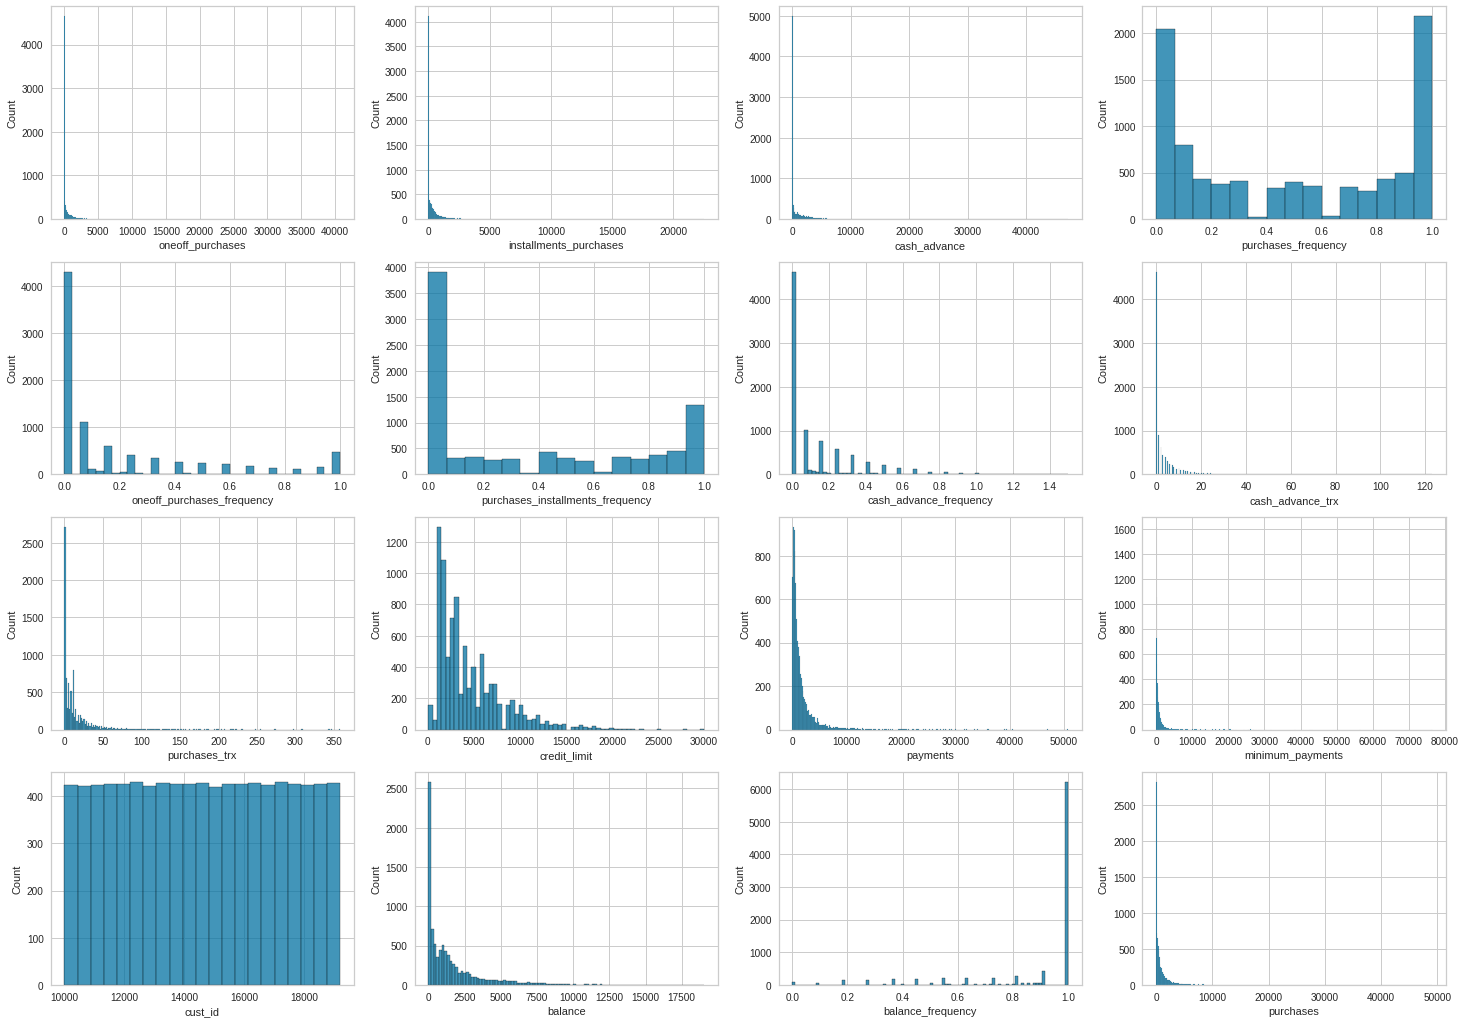

In [65]:
fig, ax = plt.subplots(4,4,figsize=(25,18))
features = num_attributes.drop('tenure',axis=1).columns
for k in range(16):
  q, mod = divmod(k,4)
  sns.histplot(data=df1,x=features[k],ax=ax[q-1][mod])

# 2. Feature Filtering

In [79]:
df2 = df1.copy()

In [80]:
print('The database has a total of {} negative values.'.format(df2.applymap(lambda x: 1 if x<0 else 0).sum().sum()))

The database has a total of 0 negative values.


# 3. Feature Engineering

In [81]:
df3 = df2.copy()

## 3.1. Feature Creation

In [82]:
df3.sample(5).T

,6927,3240,1850,5603,8778
cust_id,17116.000000,13334.000000,11911.000000,15759.000000,19017.000000
balance,990.456040,182.085903,2586.533933,59.325240,80.493080
balance_frequency,1.000000,1.000000,1.000000,1.000000,0.300000
purchases,0.000000,1935.160000,400.000000,527.630000,500.000000
oneoff_purchases,0.000000,1935.160000,400.000000,0.000000,500.000000
installments_purchases,0.000000,0.000000,0.000000,527.630000,0.000000
cash_advance,18.724916,0.000000,0.000000,0.000000,544.979339
purchases_frequency,0.000000,0.833333,0.083333,1.000000,0.300000
oneoff_purchases_frequency,0.000000,0.833333,0.083333,0.000000,0.300000
purchases_installments_frequency,0.000000,0.000000,0.000000,0.900000,0.000000


In [129]:
df_ref = df3[['cust_id','purchases_frequency','purchases_trx','balance','purchases']].copy()

df_ref.sample(5).T

,8237,8377,5273,6558,4267
cust_id,18458.000000,18601.000000,15421.000000,16737.000000,14385.000000
purchases_frequency,0.000000,0.000000,0.916667,0.250000,0.666667
purchases_trx,0.000000,0.000000,31.000000,4.000000,9.000000
balance,2144.040539,412.149369,1500.810722,44.539341,19.548437
purchases,0.000000,0.000000,2340.870000,94.300000,266.560000


# 4. EDA (Exploratory Data Analysis)

In [130]:
df4 = df_ref.copy()

# 5. Data Preparation

In [131]:
df5 = df4.copy()

In [132]:
df5.head()

,cust_id,purchases_frequency,purchases_trx,balance,purchases
0,10001,0.166667,2,40.900749,95.40
1,10002,0.000000,0,3202.467416,0.00
2,10003,1.000000,12,2495.148862,773.17
3,10004,0.083333,1,1666.670542,1499.00
4,10005,0.083333,1,817.714335,16.00


In [133]:
## Standard Scaler
ss = pp.StandardScaler()

for feature in df5.columns.tolist()[2:]:
  df5[feature] = ss.fit_transform(df5[[feature]])

# 6. Feature Selection

In [134]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

In [135]:
X = df6.drop('cust_id',axis=1)

In [136]:
clusters = [2,3,4,5,6,7]

In [137]:
model = KMeans(random_state=101)

## 7.1. Within-Cluster Sum of Square (WSS)

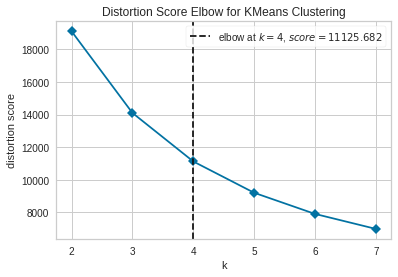

In [138]:
kmeans = KElbowVisualizer(model,k=clusters, metric='distortion',timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2. Sillhouette Score

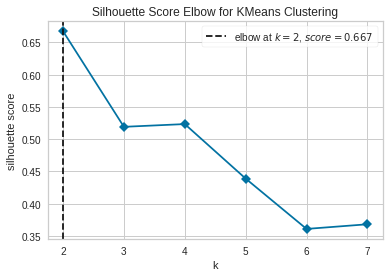

In [139]:
kmeans = KElbowVisualizer(model,k=clusters, metric='silhouette',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

### 7.2.1. Silhouette Analysis

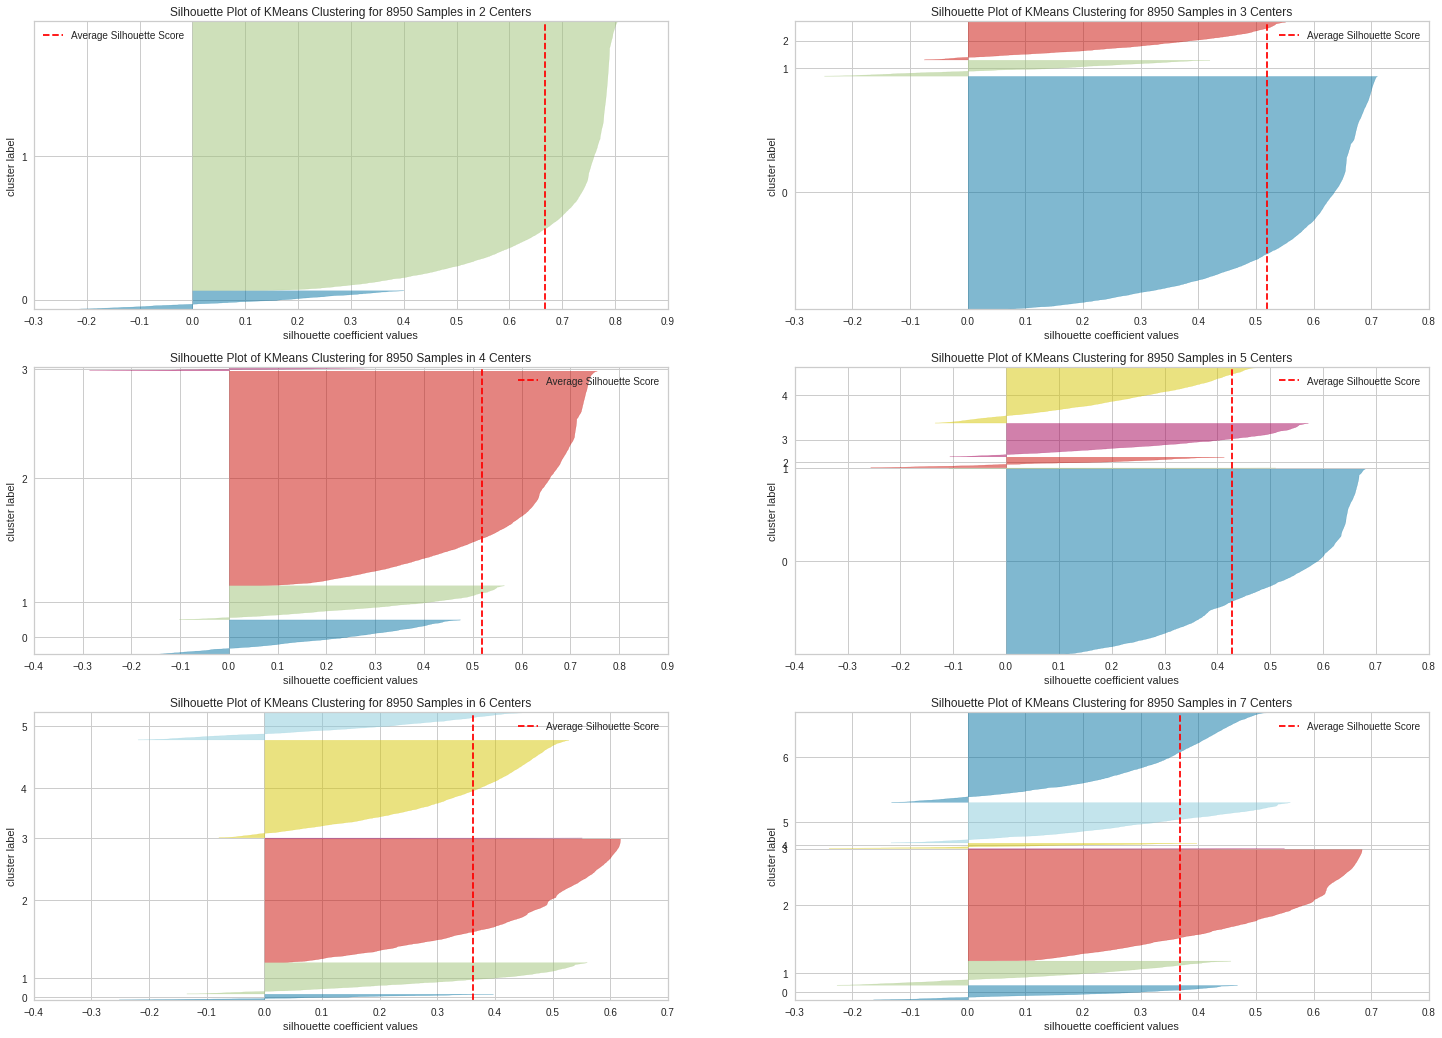

In [140]:
fig, ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
  km = KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=101)
  q, mod = divmod(k,2)

  visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 7.3. Davies Bouldin Score

In [141]:
davies_list = []

for k in clusters:
  # model definition
  kmeans_model = KMeans(n_clusters=k,random_state=101)

  # model training
  kmeans_model.fit(X)

  # model predict
  labels = kmeans_model.predict(X)

  # model performance
  dav = m.davies_bouldin_score(X, labels)

  davies_list.append(dav)

Text(0, 0.5, 'Davies Boulding Score')

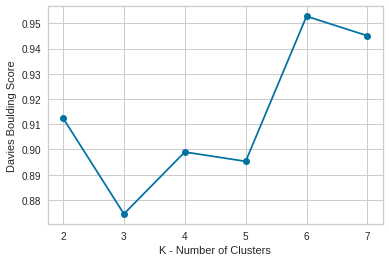

In [142]:
plt.plot(clusters, davies_list,marker='o')
plt.xlabel('K - Number of Clusters')
plt.ylabel('Davies Boulding Score')

# 8. Model Training

## 8.1. K-Means

In [153]:
# Model Definition
k = 4
kmeans = KMeans(init='random',n_clusters=k,random_state=101)

# Model Training
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [154]:
# WWS (Within-Cluster Sum of Square)
print('WWS value: {:.2f}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {:.2f}'.format(m.silhouette_score(X,labels)))

# Davies Bouldin Score
print('Davies Boulding Score: {:.2f}'.format(davies_list[1]))

WWS value: 11126.64
SS value: 0.52
Davies Boulding Score: 0.87


# 9. Cluster Analysis

In [155]:
df9 = df3[['cust_id','purchases_frequency','purchases_trx','balance','purchases']].copy()
df9['cluster'] = labels
df9.head()

,cust_id,purchases_frequency,purchases_trx,balance,purchases,cluster
0,10001,0.166667,2,40.900749,95.40,2
1,10002,0.000000,0,3202.467416,0.00,2
2,10003,1.000000,12,2495.148862,773.17,2
3,10004,0.083333,1,1666.670542,1499.00,2
4,10005,0.083333,1,817.714335,16.00,2


## 9.1. Two-Dimentions Plot

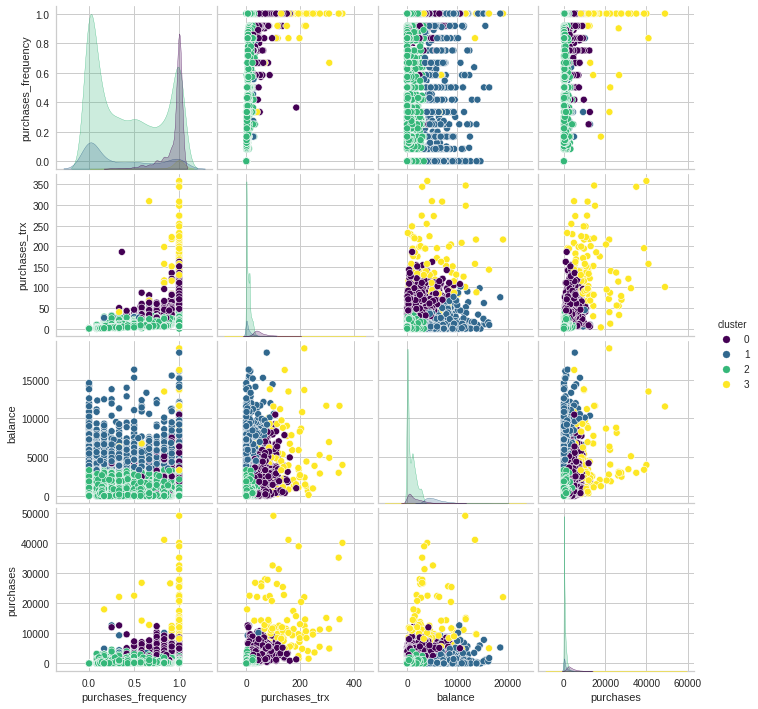

In [158]:
df_viz = df9.drop('cust_id',axis=1)
sns.pairplot(df_viz,hue='cluster',palette='viridis')

## 9.2. UMAP

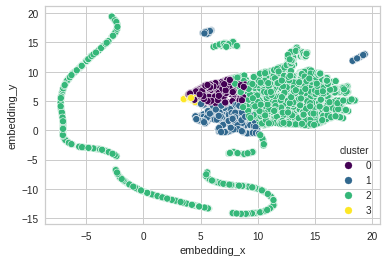

In [159]:
# Quciker from larger datasets but more difficult to visualize
# Change n_neighbors to see something similar to a local structure (\/) ou global structure (/\)
reducer = umap.UMAP(n_neighbors=20,random_state=101)
embedding = reducer.fit_transform(X)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',data=df_viz,hue='cluster',palette='viridis')

## 9.3. t-SNE

## 9.4. Cluster Profile

In [160]:
df9.columns.tolist()

['cust_id',
 'purchases_frequency',
 'purchases_trx',
 'balance',
 'purchases',
 'cluster']

In [161]:
# Number of Customers
df_cluster = df9[['cust_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['cust_id']/df_cluster['cust_id'].sum()),2)

df_aux = df9[['purchases_frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

df_aux = df9[['purchases_trx','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

df_aux = df9[['balance','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

df_aux = df9[['purchases','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

In [162]:
df_cluster

,cluster,cust_id,perc_customer,purchases_frequency,purchases_trx,balance,purchases
0,0,1086,12.13,0.943107,51.504604,1687.539475,3318.556648
1,1,1057,11.81,0.345717,9.030274,5835.464914,709.943869
2,2,6702,74.88,0.432510,7.584602,824.265109,474.702371
3,3,105,1.17,0.955397,146.114286,4543.530133,13741.569333


### Cluster 01 (⭐⭐⭐⭐⭐)
- Number of Customers: **105** (1.17% of customers)
- Frequency of Purchases (from 0 to 1): **0.95**
- Number of Purchases Transactions Made: **146**
- Amount of Money Owned to Credit Card Company: **$4543.53**
- Amount of Purchases made from Account: **13741**

### Cluster 02 (⭐⭐⭐⭐)
- Number of Customers: **1086** (12.13% of customers)
- Frequency of Purchases (from 0 to 1): **0.94**
- Number of Purchases Transactions Made: **51**
- Amount of Money Owned to Credit Card Company: **$1687.53**
- Amount of Purchases made from Account: **3318**

### Cluster 03 (⭐⭐⭐)
- Number of Customers: **1057** (11.81% of customers)
- Frequency of Purchases (from 0 to 1): **0.34**
- Number of Purchases Transactions Made: **9**
- Amount of Money Owned to Credit Card Company: **$5835.46**
- Amount of Purchases made from Account: **709**

### Cluster 04 (⭐⭐)
- Number of Customers: **6702** (74.88% of customers)
- Frequency of Purchases (from 0 to 1): **0.43**
- Number of Purchases Transactions Made: **7**
- Amount of Money Owned to Credit Card Company: **$824.26**
- Amount of Purchases made from Account: **474**

# 10. Deploy to Production